In [1]:
import sys
import os
import time
import collections
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. NN基礎

## data

In [2]:
# data
def load_spiral_data(seed=1984):
  np.random.seed(seed)
  N = 100  # クラスごとのサンプル数
  DIM = 2  # データの要素数
  CLS_NUM = 3  # クラス数

  x = np.zeros((N*CLS_NUM, DIM))
  t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=int)

  for j in range(CLS_NUM):
      for i in range(N):#N*j, N*(j+1)):
          rate = i / N
          radius = 1.0*rate
          theta = j*4.0 + 4.0*rate + np.random.randn()*0.2

          ix = N*j + i
          x[ix] = np.array([radius*np.sin(theta),
                            radius*np.cos(theta)]).flatten()
          t[ix, j] = 1

  return x, t

## functions

In [3]:
# functions

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def tanh(x):
  return np.tanh(x)

def softmax(x):
  if x.ndim == 2:
      x = x - x.max(axis=1, keepdims=True)
      x = np.exp(x)
      x /= x.sum(axis=1, keepdims=True)
  elif x.ndim == 1:
      x = x - np.max(x)
      x = np.exp(x) / np.sum(np.exp(x))

  return x


def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)
    
  if t.size == y.size:
    t = t.argmax(axis=1)
  
  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

## layers

In [54]:
# layers

class MatMul:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.x = None
    
  def forward(self, x):
    W, = self.params
    out = x @ W
    self.x = x
    
    return out
  
  def backward(self, dout):
    W, = self.params
    dx = dout @ W.T
    dW = self.x.T @ dout
    self.grads[0][...] = dW
    
    return dx
  

class Sigmoid:
  def __init__(self):
    self.params = []
    self.grads = []
    self.out = None
    
  def forward(self, x):
    out = sigmoid(x)
    self.out = out
    return out
  
  def backward(self, dout):
    dx = dout * self.out * (1 - self.out)
    return dx
  
  
class Affine:
  def __init__(self, W, b):
    self.params = [W, b]
    self.grads = [np.zeros_like(W), np.zeros_like(b)]
    self.x = None
    
  def forward(self, x):
    W, b = self.params
    out = x @ W + b
    self.x = x
    return out
  
  def backward(self, dout):
    W, b = self.params
    dx = dout @ W.T
    dW = self.x.T @ dout
    db = np.sum(dout, axis=0)
    self.grads[0][...] = dW
    self.grads[1][...] = db
    return dx


class Softmax:
  def __init__(self):
    self.params, self.grads = [], []
    self.out = None
  
  def forward(self, x):
    self.out = softmax(x)
    return self.out
  
  def backward(self, dout):
    dx = self.out * dout
    sumdx = np.sum(dx, axis=1, keepdims=True)
    dx -= self.out * sumdx
    return dx
  

class SoftmaxWithLoss:
  def __init__(self):
    self.params = []
    self.grads = []
    self.y = None
    self.t = None
    
  def forward(self, x, t):
    self.y = softmax(x)
    self.t = t
    
    if self.t.size == self.y.size:
      self.t = self.t.argmax(axis=1)
    
    loss = cross_entropy_error(self.y, self.t)
    return loss
  
  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    
    dx = self.y.copy()
    dx[np.arange(batch_size), self.t] -= 1
    dx *= dout
    dx /= batch_size
    return dx
  
  
class Dropout:
  def __init__(self, dropout_ratio=0.5):
    self.params, self.grads = [], []
    self.dropout_ratio = dropout_ratio
    self.mask = None
    
  def forward(self, x, train_flg=True):
    if train_flg:
      self.mask = np.random.rand(*x.shape) > self.dropout_ratio
      return x * self.mask
    return x * (1 - self.dropout_ratio)
  
  def backward(self, dout):
    return dout * self.mask

## networks

In [5]:
# network

class TwoLayerNet:
  '''
  X -> (Affine -> Sigmoid) -> (Affine) -> [SoftmaxWithLoss] -> L 
  '''
  def __init__(self, input_size, hidden_size, output_size):
    I, H, O = input_size, hidden_size, output_size
    
    W1 = 0.01 * np.random.randn(I, H)
    b1 = np.zeros(H)
    W2 = 0.01 * np.random.randn(H, O)
    b2 = np.zeros(O)
    
    self.layers = [
      Affine(W1, b1),
      Sigmoid(),
      Affine(W2, b2)
    ]
    self.loss_layer = SoftmaxWithLoss()
    
    # すべてのパラメータをリストにまとめる
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
  
  def predict(self, x):
    for layer in self.layers:
      x = layer.forward(x)
    
    return x
  
  def forward(self, x, t):
    score = self.predict(x)
    loss = self.loss_layer.forward(score, t)
    return loss
  
  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

## optimizers

In [16]:
# optimizer

class SGD:
  def __init__(self, lr=0.01):
    self.lr = lr
    
  def update(self, params, grads):
    for i in range(len(params)):
      params[i] -= self.lr * grads[i]
      

class Momentum:
  '''
  v = alpha * v - lr * dW
  W = W + v
  '''
  def __init__(self, lr=0.01, momentum=0.9):
    self.lr = lr
    self.momentum = momentum
    self.v = None
    
  def update(self, params, grads):
    if self.v is None:
      self.v = []
      for i in range(len(params)):
        self.v.append(np.zeros_like(params[i]))
        
    for i in range(len(params)):
      self.v[i] = self.momentum * self.v[i] - self.lr * grads[i]
      params[i] += self.v[i]


class AdaGrad:
  '''
  h = h + dW * dW
  W = W - lr * dW / sqrt(h) 
  '''
  def __init__(self, lr=0.01):
    self.lr = lr
    self.h = None
    
  def update(self, params, grads):
    if self.h is None:
      self.h = []
      for i in range(len(params)):
        self.h.append(np.zeros_like(params[i]))
        
    for i in range(len(params)):
      self.h[i] += grads[i]**2
      params[i] -= self.lr * grads[i] / np.sqrt(self.h[i] + 1e-7)
      

class RMSProp:
  '''
  h = beta * h + (1 - beta) * dW^2
  W = W - lr * dW / sqrt(h)
  '''
  def __init__(self, lr=0.01, decay_rate=0.99):
    self.lr = lr
    self.decay_rate = decay_rate
    self.h = None
    
  def update(self, params, grads):
    if self.h is None:
      self.h = []
      for i in range(len(params)):
        self.h.append(np.zeros_like(params[i]))
    
    for i in range(len(params)):
      self.h[i] = self.decay_rate * self.h[i] + (1 - self.decay_rate) * grads[i]**2
      params[i] -= self.lr * grads[i] / np.sqrt(self.h[i] + 1e-7)


class Adam:
  '''
  v = beta1 * v + (1 - beta1) * dW
  h = beta2 * h + (1 - beta2) * dW**2
  vhat = v / (1 - beta1^t)
  hhat = h / (1 - beta2^t)
  W = W - lr * vhat / sqrt(hhat)
  '''
  def __init__(self, lr=0.01, beta1=0.9, beta2=0.999):
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.v, self.h = None, None
    self.t = 0
    
  def update(self, params, grads):
    if self.v is None:
      self.v = []
      for i in range(len(params)):
        self.v.append(np.zeros_like(params[i]))
        
    if self.h is None:
      self.h = []
      for i in range(len(params)):
        self.h.append(np.zeros_like(params[i]))
    
    self.t += 1
    lr = self.lr * np.sqrt(1 - self.beta2**self.t) / (1 - self.beta1**self.t) 
    for i in range(len(params)):
      self.v[i] = self.beta1 * self.v[i] + (1 - self.beta1) * grads[i]
      self.h[i] = self.beta2 * self.h[i] + (1 - self.beta2) * grads[i]**2
      params[i] -= lr * self.v[i] / (np.sqrt(self.h[i]) + 1e-7)

## Trainer

In [7]:
# trainer

class Trainer:
  def __init__(self, model, optimizer):
    self.model = model
    self.optimizer = optimizer
    self.loss_list = []
    self.eval_interval = None
    self.current_epoch = 0
    
  def fit(self, x, t, max_epoch=10, batch_size=32, eval_interval=20, max_grad=None, print_loss=True):
    '''
    x: 入力データ
    t: 教師ラベル
    max_epoch: 学習を行うエポック数
    batch_size: ミニバッチサイズ
    eval_interval: 結果（平均損失など）を表示（記録）するインターバル
    max_grad: 勾配の最大ノルム
    '''
    data_size = x.shape[0]
    max_iters = data_size // batch_size
    self.eval_interval = eval_interval
    model, optimizer = self.model, self.optimizer
    total_loss = 0
    loss_count = 0
    
    
    start_time = time.time()
    for epoch in range(max_epoch):
      idx = np.random.permutation(data_size)
      x = x[idx]
      t = t[idx]
      
      for i in range(max_iters):
        batch_x = x[i*batch_size:(i+1)*batch_size]
        batch_t = t[i*batch_size:(i+1)*batch_size]
        
        loss = model.forward(batch_x, batch_t)
        model.backward(dout=1)
        params, grads = remove_duplicate(model.params, model.grads)
        if max_grad is not None:
          clip_grads(grads, max_grad)
        optimizer.update(params, grads)
        
        total_loss += loss
        loss_count += 1
        
        if (eval_interval is not None) and (i % eval_interval == 0):
          avg_loss = total_loss / loss_count
          elapsed_time = time.time() - start_time
          if print_loss:
            print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                            % (self.current_epoch + 1, i + 1, max_iters, elapsed_time, avg_loss))
          self.loss_list.append(avg_loss)
          total_loss = 0
          loss_count = 0
        
      self.current_epoch += 1
        
  def plot(self, ylim=None):
    x = np.arange(len(self.loss_list))
    if ylim is not None:
      plt.ylim(*ylim)
    plt.plot(x, self.loss_list, label='train')
    plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
   
  
def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

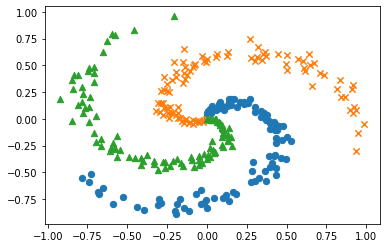

In [8]:
x, t = load_spiral_data()

N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
  plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

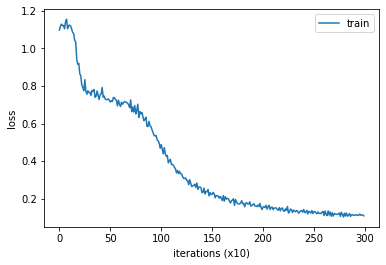

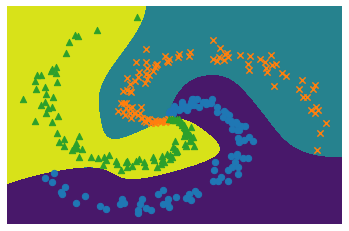

In [20]:
# hyper-parameter
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

# data, model, optimizer
x, t = load_spiral_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)
# optimizer = Momentum(lr=learning_rate)
# optimizer = AdaGrad(lr=learning_rate)
# optimizer = Adam(lr=learning_rate)

trainer = Trainer(model, optimizer)
trainer.fit(x, t, max_epoch, batch_size, eval_interval=10, print_loss=False)
trainer.plot()


h = 0.001
xmin, xmax = x[:,0].min() - .1, x[:,0].max() + .1
ymin, ymax = x[:,1].min() - .1, x[:,1].max() + .1

xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

x, t = load_spiral_data()
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
  plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

# 2. NLP - before word2vec

In [21]:
# util

def cos_similarity(x, y, eps=1e-8):
  return x @ y / (np.sqrt(np.sum(x**2)) * np.sqrt(np.sum(y**2)) + eps)


def preprocess(text):
  text = text.lower()
  text = text.replace('.', ' .')
  words = text.split(' ')
  
  word_to_id = {}
  id_to_word = {}
  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word
      
  corpus = np.array([word_to_id[word] for word in words])
  
  return corpus, word_to_id, id_to_word


def create_co_matrix(corpus, vocab_size, window_size=1):
  corpus_size = len(corpus)
  co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.uint32)
  
  for i, word_id in enumerate(corpus):
    left = i - window_size
    right = i + window_size
    
    if left >= 0:
      co_matrix[word_id, corpus[left]] += 1
    if right < corpus_size:
      co_matrix[word_id, corpus[right]] += 1
      
  return co_matrix


def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
  assert query in word_to_id, '%s is not found' % query
  
  print('\n[query]: %s' % (query))
  query_id = word_to_id[query]
  query_vec = word_matrix[query_id]
  
  vocab_size = len(id_to_word)
  similarity = np.zeros(vocab_size)
  
  for word_id in id_to_word.keys():
    similarity[word_id] = cos_similarity(query_vec, word_matrix[word_id])
  
  for word_id in np.argsort(-similarity)[:top+1]:
    if id_to_word[word_id] == query:
      continue
    print('  %s: %s' % (id_to_word[word_id], similarity[word_id]))
    
    
def ppmi(C, verbose=False, eps=1e-8):
  M = np.zeros_like(C, dtype=np.float32)
  N = np.sum(C)
  S = np.sum(C, axis=0)
  total = C.shape[0] * C.shape[1]
  cnt = 0
  
  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      pmi = np.log2(N * C[i, j] / (S[i] * S[j]) + eps)
      M[i, j] = max(0, pmi)
      
  return M

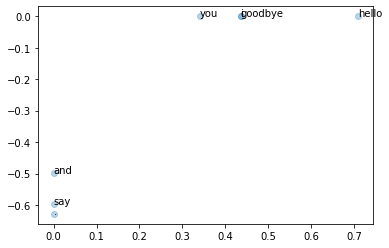

In [22]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

U, S, V = np.linalg.svd(W)

for word, word_id in word_to_id.items():
  plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
  
plt.scatter(U[:,0], U[:,1], alpha=0.3)
plt.show()

# 3. word2vec

In [23]:
# util

def create_context_target(corpus, window_size=1):
  target = corpus[window_size:-window_size]
  contexts = []
  for i in range(window_size, len(corpus)-window_size):
    cs = []
    for w in range(-window_size, window_size+1):
      if w == 0:
        continue
      cs.append(corpus[i+w])
    contexts.append(cs)
    
  return np.array(contexts), np.array(target)


def convert_one_hot(corpus, vocab_size):
  N = corpus.shape[0]
  
  if corpus.ndim == 1:
    one_hot = np.zeros((N, vocab_size), dtype=np.uint32)
    for i, word_id in enumerate(corpus):
      one_hot[i, word_id] = 1
      
  elif corpus.ndim == 2:
    C = corpus.shape[1]
    one_hot = np.zeros((N, C, vocab_size), dtype=np.uint32)
    for i in range(N):
      for j, word_id in enumerate(corpus[i]):
        one_hot[i, j, word_id] = 1
  
  return one_hot

In [24]:
# network

class SimpleCBOW:
  '''
  a simple version of CBOW (window size = 1)
  '''
  def __init__(self, vocab_size, hidden_size):
    V, H = vocab_size, hidden_size
    
    W_in = 0.01 * np.random.randn(V, H).astype(np.float32)
    W_out = 0.01 * np.random.randn(H, V).astype(np.float32)
    
    self.in_layer0 = MatMul(W_in)
    self.in_layer1 = MatMul(W_in)
    self.out_layer = MatMul(W_out)
    self.loss_layer = SoftmaxWithLoss()
    
    layers = [self.in_layer0, self.in_layer1, self.out_layer]
    
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads
    
    self.word_vecs = W_in
    
  def forward(self, contexts, target):
    h0 = self.in_layer0.forward(contexts[:, 0])
    h1 = self.in_layer1.forward(contexts[:, 1])
    h = (h0 + h1) / 2.0
    score = self.out_layer.forward(h)
    loss = self.loss_layer.forward(score, target)
    return loss
  
  def backward(self, dout=1):
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(ds)
    da *= 0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    
    
class SimpleSkipgram:
  '''
  a simple version of skip-gram (window size = 1)
  '''
  def __init__(self, vocab_size, hidden_size):
    V, H = vocab_size, hidden_size
    
    W_in = 0.01 * np.random.randn(V, H).astype(np.float32)
    W_out = 0.01 * np.random.randn(H, V).astype(np.float32)
    
    self.in_layer = MatMul(W_in)
    self.out_layer = MatMul(W_out)
    self.loss_layer0 = SoftmaxWithLoss()
    self.loss_layer1 = SoftmaxWithLoss()
    
    layers = [self.in_layer, self.out_layer]
    
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads
  
    self.word_vecs = W_in
  
  def forward(self, target, contexts):
    h = self.in_layer.forward(target)
    score = self.out_layer.forward(h)
    loss0 = self.loss_layer0.forward(score, contexts[:, 0])
    loss1 = self.loss_layer1.forward(score, contexts[:, 1])
    loss = loss0 + loss1
    return loss
  
  def backward(self, dout=1):
    dl1 = self.loss_layer1.backward(dout)
    dl0 = self.loss_layer0.backward(dout)
    ds = dl0 + dl1
    dh = self.out_layer.backward(ds)
    self.in_layer.backward(dh)

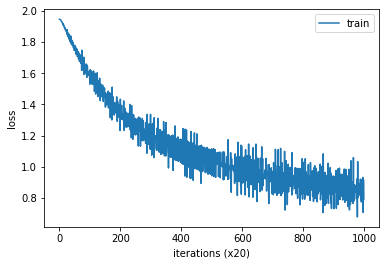

In [25]:
# hyper-parameter
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000
learning_rate = 0.01

# training data
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)

contexts, target = create_context_target(corpus)
contexts = convert_one_hot(contexts, vocab_size)
target = convert_one_hot(target, vocab_size)

# training
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = AdaGrad(lr=learning_rate)
trainer = Trainer(model, optimizer)
trainer.fit(contexts, target, max_epoch, batch_size, print_loss=False)
trainer.plot()

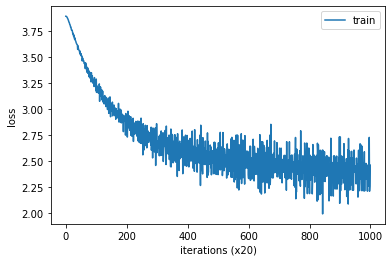

In [26]:
# hyper-parameter
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000
learning_rate = 0.01

# training data
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)

contexts, target = create_context_target(corpus)
contexts = convert_one_hot(contexts, vocab_size)
target = convert_one_hot(target, vocab_size)

# training
model = SimpleSkipgram(vocab_size, hidden_size)
optimizer = AdaGrad(lr=learning_rate)
trainer = Trainer(model, optimizer)
trainer.fit(target, contexts, max_epoch, batch_size, print_loss=False)
trainer.plot()

# 4. improving word2vec

## util

In [27]:
# util

class UnigramSampler:
  def __init__(self, corpus, power, sample_size):
    self.sample_size = sample_size
    self.vocab_size = None
    self.word_p = None
    
    counts = collections.Counter()
    for word_id in corpus:
      counts[word_id] += 1
    
    vocab_size = len(counts)
    self.vocab_size = vocab_size
    
    self.word_p = np.zeros(vocab_size)
    for i in range(vocab_size):
      self.word_p[i] = counts[i]
    
    self.word_p = np.power(self.word_p, power)
    self.word_p /= np.sum(self.word_p)
    
    
  def get_negative_sample(self, target):
    batch_size = target.shape[0]
    sample_size = self.sample_size
    
    negative_sample = np.zeros((batch_size, sample_size), dtype=np.uint32)
    for i in range(batch_size):
      word_p = self.word_p.copy()
      word_p[target[i]] = 0
      word_p /= np.sum(word_p)
      negative_sample[i] = np.random.choice(self.vocab_size, size=sample_size, replace=False, p=word_p)
      
    return negative_sample

## layers

In [28]:
# layer

class SigmoidWithLoss:
  def __init__(self):
    self.params = []
    self.grads = []
    self.y = None
    self.t = None
    self.loss = None
    
  def forward(self, x, t):
    self.y = sigmoid(x)
    self.t = t
    self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)
    return self.loss
  
  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    dx = dout * (self.y - self.t) / batch_size
    return dx
  
    
class Embedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None
    
  def forward(self, idx):
    W, = self.params
    out = W[idx]
    self.idx = idx
    return out
  
  def backward(self, dout):
    '''
    backwardの本来の目的はWの更新のための勾配取得
    -> doutとidxだけ保持しておき、Wの更新のときにそれを利用する方がメモリ効率は良い
    -> しかし、レイヤーモジュールの実装の都合上、一旦Wと同サイズのdWを用意している
    '''
    dW, = self.grads
    dW[...] = 0
    np.add.at(dW, self.idx, dout)
    # for i, word_id in enumerate(self.idx):
    #   dW[word_id] += dout[i]
    
    
class EmbeddingDot:
  def __init__(self, W):
    self.embed = Embedding(W)
    self.params = self.embed.params
    self.grads = self.embed.grads
    self.cache = None
    
  def forward(self, h, idx):
    target_W = self.embed.forward(idx)
    out = np.diag(h @ target_W.T)
    self.cache = (h, target_W)
    return out
  
  def backward(self, dout):
    h, target_W = self.cache
    dout = dout.reshape(dout.shape[0], 1)
    
    dh = dout * target_W
    dtarget_W = h * dout
    self.embed.backward(dtarget_W)
    return dh
  

class NegativeSamplingLoss:
  def __init__(self, W, corpus, power, sample_size):
    self.sample_size = sample_size
    self.sampler = UnigramSampler(corpus, power, sample_size)
    self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
    self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
    
    self.params, self.grads = [], []
    for layer in self.embed_dot_layers:
      self.params += layer.params
      self.grads += layer.grads
      
  def forward(self, h, target):
    batch_size = target.shape[0]
    negative_sample = self.sampler.get_negative_sample(target)
 
    # positive sample
    score = self.embed_dot_layers[0].forward(h, target)
    correct_label = np.ones(batch_size, dtype=np.uint8)
    loss = self.loss_layers[0].forward(score, correct_label)
    
    # negative sample
    negative_label = np.zeros(batch_size, dtype=np.uint8)
    for i in range(self.sample_size):
      negative_target = negative_sample[:,i]
      score = self.embed_dot_layers[i+1].forward(h, negative_target)
      loss += self.loss_layers[i+1].forward(score, negative_label)
    
    return loss
  
  def backward(self, dout=1):
    dh = 0
    for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
      dscore = l0.backward(dout)
      dh += l1.backward(dscore)
    return dh

## network

In [29]:
# network

class CBOW:
  '''
  CBOW
  
  vocab_size: 語彙数
  hidden_size: 分散表現の次元数
  window_size: CBOWのウィンドウサイズ
  corpus: コーパス表現
  '''
  def __init__(self, vocab_size, hidden_size, window_size, corpus):
    V, H = vocab_size, hidden_size
    
    W_in = 0.01 * np.random.randn(V, H).astype(np.float32)
    W_out = 0.01 * np.random.randn(V, H).astype(np.float32)
    
    self.in_layers = []
    for i in range(window_size * 2):
      in_layer = Embedding(W_in)
      self.in_layers.append(in_layer)
    
    self.ns_loss_layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
    
    self.layers = self.in_layers + [self.ns_loss_layer]
    
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
    
    self.word_vecs = W_in
    
    
  def forward(self, contexts, target):
    h = 0
    for i, layer in enumerate(self.in_layers):
      h += layer.forward(contexts[:, i])
    h /= len(self.in_layers)
    
    loss = self.ns_loss_layer.forward(h, target)
    return loss
  
  def backward(self, dout=1):
    dout = self.ns_loss_layer.backward(dout)
    dout /= len(self.in_layers)
    for layer in self.in_layers:
      layer.backward(dout)
      
      
class Skipgram:
  '''
  Skipgram
  
  vocab_size: 語彙数
  hidden_size: 分散表現の次元数
  window_size: CBOWのウィンドウサイズ
  corpus: コーパス表現
  '''
  def __init__(self, vocab_size, hidden_size, window_size, corpus):
    V, H = vocab_size, hidden_size
    
    W_in = 0.01 * np.random.randn(V, H).astype(np.float32)
    W_out = 0.01 * np.random.randn(V, H).astype(np.float32)
    
    self.in_layer = Embedding(W_in)
    self.ns_loss_layers = []
    for i in range(window_size * 2):
      ns_loss_layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
      self.ns_loss_layers.append(ns_loss_layer)
      
    self.layers = [ self.in_layer ] + self.ns_loss_layers
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
    
    self.word_vecs = W_in
    
  def forward(self, contexts, target):
    h = self.in_layer.forward(target)
    loss = 0
    for i, layer in enumerate(self.ns_loss_layers):
      loss += layer.forward(h, contexts[:, i])
    return loss
  
  def backward(self, dout=1):
    dh = 0
    for layer in self.ns_loss_layers:
      dh += layer.backward(dout)
    self.in_layer.backward(dh)

## training

In [30]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)

sampler = UnigramSampler(corpus, power=0.75, sample_size=2)
sampler.get_negative_sample(contexts)

array([[6, 5],
       [2, 5],
       [2, 5],
       [3, 5],
       [6, 4],
       [5, 3]], dtype=uint32)

### CBOW

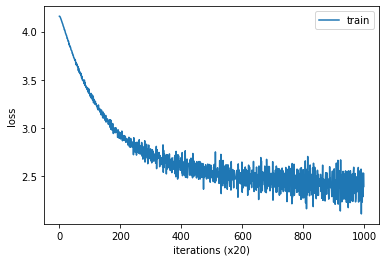

In [31]:
# hyper-parameter
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000
learning_rate = 0.01

# training data
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)

contexts, target = create_context_target(corpus)

# training
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = AdaGrad(lr=learning_rate)
trainer = Trainer(model, optimizer)
trainer.fit(contexts, target, max_epoch, batch_size, print_loss=False)
trainer.plot()

### skip-gram

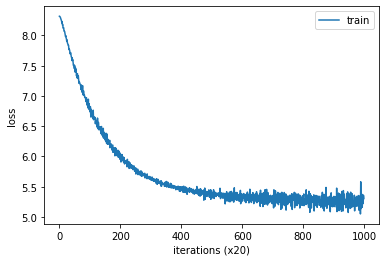

In [32]:
# hyper-parameter
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000
learning_rate = 0.01

# training data
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)

contexts, target = create_context_target(corpus)

# training
model = Skipgram(vocab_size, hidden_size, window_size, corpus)
optimizer = AdaGrad(lr=learning_rate)
trainer = Trainer(model, optimizer)
trainer.fit(contexts, target, max_epoch, batch_size, print_loss=False)
trainer.plot()

# 5. RNN

## time layers

In [33]:
# util

def clip_grads(grads, max_norm):
  '''
  勾配爆発を回避する
  '''
  total_norm = 0
  for grad in grads:
    total_norm += np.sum(grad**2)
  total_norm = np.sqrt(total_norm)
  
  rate = max_norm / total_norm
  if rate < 1:
    for grad in grads:
      grad *= rate

In [34]:
# time layer

class TimeEmbedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.layers = None
    self.W = W
    
  def forward(self, xs):
    N, T = xs.shape
    V, D = self.W.shape
    
    out = np.empty((N, T, D), dtype=np.float32)
    self.layers = []
    
    for t in range(T):
      layer = Embedding(self.W)
      self.layers.append(layer)
      out[:, t, :] = layer.forward(xs[:, t])
    
    return out
  
  def backward(self, dout):
    N, T, D = dout.shape
    
    grad = 0
    for t in range(T):
      layer = self.layers[t]
      layer.backward(dout[:, t, :])
      grad += layer.grads[0]
    
    self.grads[0][...] = grad
    

class TimeAffine:
  def __init__(self, W, b):
    self.params = [W, b]
    self.grads = [np.zeros_like(W), np.zeros_like(b)]
    self.xs = None
    
  def forward(self, xs):
    N, T, D = xs.shape
    W, b = self.params
    self.xs = xs
    
    xs_reshaped = xs.reshape(N*T, -1)
    out = xs_reshaped @ W + b
    out = out.reshape(N, T, -1)
    return out
  
  def backward(self, dout):
    xs = self.xs
    N, T, D = xs.shape
    W, b = self.params
    
    dout = dout.reshape(N*T, -1)
    xs_reshaped = xs.reshape(N*T, -1)
    
    db = np.sum(dout, axis=0)
    dW = xs_reshaped.T @ dout
    dxs = dout @ W.T
    dxs = dxs.reshape(N, T, -1)
    
    self.grads[0][...] = dW
    self.grads[1][...] = db
    
    return dxs
  
  
class TimeSoftmaxWithLoss:
  def __init__(self):
    self.params, self.grads = [], []
    self.cache = None
    self.ignore_label = -1
    
  def forward(self, xs, ts):
    N, T, D = xs.shape
    
    if ts.ndim == 3:
      ts = np.argmax(ts, axis=2)
      
    mask = (ts != self.ignore_label)
    
    xs = xs.reshape(N*T, -1)
    ts = ts.reshape(N*T)
    mask = mask.reshape(N*T)
    
    ys = softmax(xs)
    ls = np.log(ys[np.arange(N*T), ts])
    ls *= mask  # ignore_labelで指定された教師ラベルの箇所は損失を0にする
    loss = -np.sum(ls)
    loss /= mask.sum()
    
    self.cache = (ts, ys, mask, (N, T, D))
    return loss
  
  def backward(self, dout=1):
    ts, ys, mask, (N, T, D) = self.cache
    
    dx = ys
    dx[np.arange(N*T), ts] -= 1
    dx *= dout
    dx /= mask.sum()
    dx *= mask[:, np.newaxis]  # ignore_labelで指定された教師ラベルの箇所は勾配を0にする
    
    dx = dx.reshape(N, T, D)
    return dx

## RNN layers

In [35]:
# RNN-layer

class RNN:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None
    
  def forward(self, x, h_prev):
    Wx, Wh, b = self.params
    t = h_prev@Wh + x@Wx + b
    h_next = tanh(t)
    self.cache = (x, h_prev, h_next)
    return h_next
  
  def backward(self, dh_next):
    Wx, Wh, b = self.params
    x, h_prev, h_next = self.cache
    
    dt = dh_next * (1 - h_next**2)
    db = np.sum(dt, axis=0)
    dWh = h_prev.T @ dt
    dh_prev = dt @ Wh.T
    dWx = x.T @ dt
    dx = dt @ Wx.T
    
    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db
    
    return dx, dh_prev
  
  
class TimeRNN:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None
    
    self.h, self.dh = None, None
    self.stateful = stateful
    
  def set_state(self, h):
    self.h = h
    
  def reset_state(self):
    self.h = None
    
  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    D, H = Wx.shape
    
    self.layers = []
    hs = np.empty((N, T, H), dtype=np.float32)
    
    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype=np.float32)
      
    for t in range(T):
      layer = RNN(Wx, Wh, b)
      self.layers.append(layer)
      self.h = layer.forward(xs[:, t, :], self.h)
      hs[:, t, :] = self.h
      
    return hs
  
  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D, H = Wx.shape
    
    dxs = np.empty((N, T, D), dtype=np.float32)
    dh = 0
    grads = [0, 0, 0]
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh = layer.backward(dhs[:, t, :] + dh)
      dxs[:, t, :] = dx
    
      for i, grad in enumerate(layer.grads):
        grads[i] += grad
      
    self.dh = dh
    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
    
    return dxs

## networks

In [36]:
# network

class SimpleRNNLM:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    
    # Xavierの初期値を利用
    # 前層のニューロン数をnとして、標準偏差 1/sqrt(n) を持つ分布を使用
    embed_W = (np.random.randn(V, D) / 100).astype(np.float32)
    rnn_Wx = (np.random.randn(D, H) / np.sqrt(D)).astype(np.float32)
    rnn_Wh = (np.random.randn(H, H) / np.sqrt(H)).astype(np.float32)
    rnn_b = np.zeros(H).astype(np.float32)
    affine_W = (np.random.randn(H, V) / np.sqrt(H)).astype(np.float32)
    affine_b = np.zeros(V).astype(np.float32)
    
    self.layers = [
      TimeEmbedding(embed_W),
      TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
      TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.rnn_layer = self.layers[1]
    
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
      
  
  def forward(self, xs, ts):
    for layer in self.layers:
      xs = layer.forward(xs)
    loss = self.loss_layer.forward(xs, ts)
    return loss
  
  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout
  
  def reset_state(self):
    self.rnn_layer.reset_state()

## RNN Trainer

In [37]:
# trainer

class RNNLMTrainer:
  def __init__(self, model, optimizer):
    self.model = model
    self.optimizer = optimizer
    self.time_idx = None
    self.ppl_list = None
    self.eval_interval = None
    self.current_epoch = 0
  
  def get_batch(self, xs, ts, batch_size, time_size):
    batch_x = np.empty((batch_size, time_size), dtype=np.int32)
    batch_t = np.empty((batch_size, time_size), dtype=np.int32)
    
    data_size = len(xs)
    jump = data_size // batch_size
    offsets = [i * jump for i in range(batch_size)]
    
    for t in range(time_size):
      for i, offset in enumerate(offsets):
        batch_x[i, t] = xs[(offset + self.time_idx) % data_size]
        batch_t[i, t] = ts[(offset + self.time_idx) % data_size]
      self.time_idx += 1
      
    return batch_x, batch_t
    
  def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
         max_grad=None, eval_interval=20, print_loss=True):
    data_size = len(xs)
    max_iters = data_size // (batch_size * time_size)
    self.time_idx = 0
    self.ppl_list = []
    self.eval_interval = eval_interval
    model, optimizer = self.model, self.optimizer
    total_loss = 0
    loss_count = 0
    
    start_time = time.time()
    for epoch in range(max_epoch):
      for i in range(max_iters):
        batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)
        
        # 勾配を求めてパラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        params, grads = remove_duplicate(model.params, model.grads)
        if max_grad is not None:
          clip_grads(grads, max_grad)
        optimizer.update(params, grads)
        total_loss += loss
        loss_count += 1
        
        if (eval_interval is not None) and (i % eval_interval) == 0:
          ppl = np.exp(total_loss / loss_count)
          self.ppl_list.append(float(ppl))
          elapsed_time = time.time() - start_time
          if print_loss:
            print('| epoch %d |  iter %d / %d | time %d[s] | perplexity %.2f'
                            % (self.current_epoch + 1, i + 1, max_iters, elapsed_time, ppl))
          total_loss, loss_count = 0, 0
      
      self.current_epoch += 1
  
  def plot(self, ylim=None):
    x = np.arange(len(self.ppl_list))
    if ylim is not None:
      plt.ylim(*ylim)
    plt.plot(x, self.ppl_list, label='train')
    plt.xlabel('iterations (x%s)' % (self.eval_interval))
    plt.ylabel('perplexity')
    plt.legend()
    plt.show()

## training

corpus size: 7, vocabulary size: 6


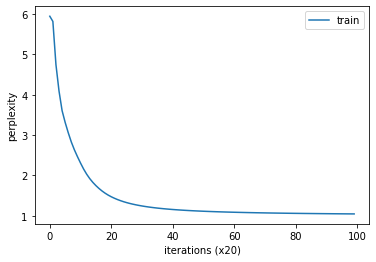

In [38]:
# hypter parameter
batch_size = 1
wordvec_size = 10
hidden_size = 10 # RNNの隠れ状態ベクトルの要素数
time_size = 3  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# training data
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
corpus_size = 7
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# generate model
model = SimpleRNNLM(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr=lr)
trainer = RNNLMTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size, print_loss=False)
trainer.plot()

# 6. Gated RNN (LSTM, GRU)

## utils

In [39]:
class BaseModel:
  def __init__(self):
    self.params, self.grads = None, None

  def forward(self, *args):
    raise NotImplementedError

  def backward(self, *args):
    raise NotImplementedError

  def save_params(self, file_name=None):
    if file_name is None:
        file_name = self.__class__.__name__ + '.pkl'

    params = [p.astype(np.float16) for p in self.params]

    with open(file_name, 'wb') as f:
        pickle.dump(params, f)

  def load_params(self, file_name=None):
    if file_name is None:
        file_name = self.__class__.__name__ + '.pkl'

    if '/' in file_name:
        file_name = file_name.replace('/', os.sep)

    if not os.path.exists(file_name):
        raise IOError('No file: ' + file_name)

    with open(file_name, 'rb') as f:
        params = pickle.load(f)

    params = [p.astype('f') for p in params]

    for i, param in enumerate(self.params):
        param[...] = params[i]

## time layers

In [40]:
# time layers

class TimeDropout:
  def __init__(self, dropout_ratio):
    self.params, self.grads = [], []
    self.dropout_ratio = dropout_ratio
    self.mask = None
    self.train_flg = True
    
  def forward(self, xs):
    if self.train_flg:
      flg = np.random.rand(*xs.shape) > self.dropout_ratio
      scale = 1 / (1 - self.dropout_ratio)
      self.mask = flg.astype(np.float32) * scale
      
      return xs * self.mask
    return xs
  
  def backward(self, dout):
    return dout * self.mask

## LSTM layers

In [41]:
# layers

class LSTM:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None
    
  def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape
    
    A = x @ Wx + h_prev @ Wh + b

    # slice
    f = A[:, :H]
    g = A[:, H:2*H]
    i = A[:, 2*H:3*H]
    o = A[:, H*3:]

    f = sigmoid(f)
    g = tanh(g)
    i = sigmoid(i)
    o = sigmoid(o)
    
    c_next = f * c_prev + g * i
    h_next = o * tanh(c_next)
    
    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next
  
  def backward(self, dh_next, dc_next):
    Wx, Wh, b = self.params
    x, h_prev, c_prev, i, f, g, o, c_next = self.cache
    
    tanh_c_next = tanh(c_next)
    
    ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
    dc_prev = ds * f
    
    do = dh_next * tanh_c_next
    di = ds * g
    dg = ds * i
    df = ds * c_prev
    
    do *= o * (1 - o)
    di *= i * (1 - i)
    dg *= 1 - g ** 2
    df *= f * (1 - f)
    
    dA = np.hstack((df, dg, di, do))
    
    db = np.sum(dA, axis=0)
    dWh = h_prev.T @ dA
    dh_prev = dA @ Wh.T
    dWx = x.T @ dA
    dx = dA @ Wx.T
    
    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db
    
    return dx, dh_prev, dc_prev
  
  
class TimeLSTM:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None
    
    self.h, self.c = None, None
    self.dh = None
    self.stateful = stateful
    
  def forward(self, xs):
    Wx, Wh, b = self.params
    H = Wh.shape[0]
    N, T, D = xs.shape
    
    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype=np.float32)
      
    if not self.stateful or self.c is None:
      self.c = np.zeros((N, H), dtype=np.float32)
    
    hs = np.empty((N, T, H), dtype=np.float32)
    self.layers = []
    
    for t in range(T):
      layer = LSTM(Wx, Wh, b)
      self.layers.append(layer)
      self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
      hs[:, t, :] = self.h
    
    return hs
  
  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D = Wx.shape[0]
    
    dxs = np.empty((N, T, D), dtype=np.float32)
    dh, dc = 0, 0
    
    grads = [0, 0, 0]
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
      dxs[:, t, :] = dx
      
      for i, grad in enumerate(layer.grads):
         grads[i] += grad
    
    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
    
    self.dh = dh
    return dxs
  
  def set_state(self, h, c=None):
    self.h, self.c = h, c
    
  def reset_state(self):
    self.h, self.c = None, None

## networks

In [42]:
# network
        
class RNNLM(BaseModel):
  def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
    V, D, H = vocab_size, wordvec_size, hidden_size
    
    embed_W = 0.01 * np.random.randn(V, D).astype(np.float32)
    lstm_Wx = (np.random.randn(D, 4*H) / np.sqrt(D)).astype(np.float32)
    lstm_Wh = (np.random.randn(H, 4*H) / np.sqrt(H)).astype(np.float32)
    lstm_b = np.zeros(4*H).astype(np.float32)
    affine_W = (np.random.randn(H, V) / np.sqrt(H)).astype(np.float32)
    affine_b = np.zeros(V).astype(np.float32)
    
    self.layers = [
      TimeEmbedding(embed_W),
      TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
      TimeAffine(affine_W, affine_b),
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layer = self.layers[1]
    
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
      
   
  def predict(self, xs):
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs
  
  def forward(self, xs, ts):
    score = self.predict(xs)
    loss = self.loss_layer.forward(score, ts)
    return loss
  
  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout
  
  def reset_state(self):
    self.lstm_layer.reset_state()
    

class BetterRNNLM(BaseModel):
  def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
    V, D, H = vocab_size, wordvec_size, hidden_size
    
    embed_W = 0.01 * np.random.randn(V, D).astype(np.float32)
    lstm_Wx1 = (np.random.randn(D, 4*H) / np.sqrt(D)).astype(np.float32)
    lstm_Wh1 = (np.random.randn(H, 4*H) / np.sqrt(H)).astype(np.float32)
    lstm_b1 = np.zeros(4*H).astype(np.float32)
    lstm_Wx2 = (np.random.randn(H, 4*H) / np.sqrt(H)).astype(np.float32)
    lstm_Wh2 = (np.random.randn(H, 4*H) / np.sqrt(H)).astype(np.float32)
    lstm_b2 = np.zeros(4*H).astype(np.float32)
    affine_b = np.zeros(V).astype(np.float32)
    
    self.layers = [
      TimeEmbedding(embed_W),
      TimeDropout(dropout_ratio),
      TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
      TimeDropout(dropout_ratio),
      TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
      TimeDropout(dropout_ratio),
      TimeAffine(embed_W.T, affine_b)  # EmbeddingとAffineで重み行列を共有（制約: V = H）
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layers = [self.layers[2], self.layers[4]]
    self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
    
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
      
  def predict(self, xs, train_flg=False):
    # Dropout layerの仕様を更新
    for layer in self.drop_layers:
      layer.train_flg = train_flg
      
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs
  
  def forward(self, xs, ts, train_flg=True):
    score = self.predict(xs, train_flg)
    loss = self.loss_layer.forward(score, ts)
    return loss
  
  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout
  
  def reset_state(self):
    for layer in self.lstm_layers:
      layer.reset_state()

## training

corpus size: 8, vocabulary size: 7


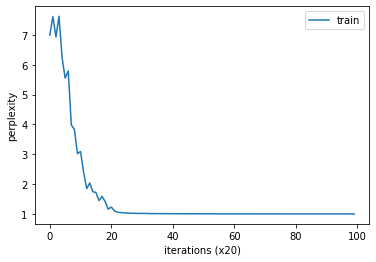

In [45]:
# hypter parameter
batch_size = 1
wordvec_size = 10
hidden_size = 10 # RNNの隠れ状態ベクトルの要素数
time_size = 3  # Truncated BPTTの展開する時間サイズ
lr = 4.0
max_epoch = 100
max_grad = 0.25

# training data
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
corpus_size = len(corpus)
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# generate model
model = RNNLM(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr=lr)
trainer = RNNLMTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, print_loss=False)
trainer.plot()

corpus size: 8, vocabulary size: 7


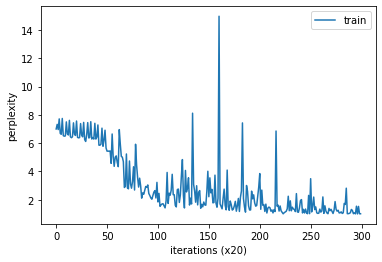

In [46]:
# hypter parameter
batch_size = 1
wordvec_size = 10
hidden_size = 10 # RNNの隠れ状態ベクトルの要素数
time_size = 3  # Truncated BPTTの展開する時間サイズ
lr = 3
max_epoch = 300
max_grad = 0.25
dropout = 0.5

# training data
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
corpus_size = len(corpus)
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# generate model
model = BetterRNNLM(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr=lr)
trainer = RNNLMTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, print_loss=False)
trainer.plot()

# 7. RNN Generating - seq2seq

## utils

In [66]:
# utils

def eval_seq2seq(model, question, correct, id_to_char, verbose=False, is_reverse=False):
  correct = correct.flatten()
  # 頭の区切り文字を除去 -> 文生成時に利用
  start_id = correct[0]
  correct = correct[1:]
  guess = model.generate(question, start_id, sample_size=len(correct))
  
  question = ''.join([id_to_char[int(word_id)] for word_id in question.flatten()])
  correct = ''.join([id_to_char[int(word_id)] for word_id in correct])
  guess = ''.join([id_to_char[int(word_id)] for word_id in guess])
  
  if verbose:
    if is_reverse:
        question = question[::-1]

    colors = {'ok': '\033[92m', 'fail': '\033[91m', 'close': '\033[0m'}
    print('Q', question)
    print('T', correct)

    is_windows = os.name == 'nt'

    if correct == guess:
        mark = colors['ok'] + '☑' + colors['close']
        if is_windows:
            mark = 'O'
        print(mark + ' ' + guess)
    else:
        mark = colors['fail'] + '☒' + colors['close']
        if is_windows:
            mark = 'X'
        print(mark + ' ' + guess)
    print('---')

  return 1 if guess == correct else 0

## generate classes

In [47]:
# RNN Gen

class RNNLMGen(RNNLM):
  def generate(self, start_id, skip_ids=None, sample_size=100):
    word_ids = [start_id]
    
    x = start_id
    while len(word_ids) < sample_size:
      x = np.array(x).reshape(1, 1)
      score = self.predict(x)
      p = softmax(score.flatten())
      
      sampled = np.random.choice(len(p), size=1, p=p)
      
      if (skip_ids is None) or (sampled not in skip_ids):
        x = sampled
        word_ids.append(int(x))
        
    return word_ids
  
  
class BetterRNNLMGen(BetterRNNLM):
  def generate(self, start_id, skip_ids=None, sample_size=100):
    word_ids = [start_id]
    
    x = start_id
    while len(word_ids) < sample_size:
      x = np.array(x).reshape(1, 1)
      score = self.predict(x)
      p = softmax(score.flatten())
      
      sampled = np.random.choice(len(p), size=1, p=p)
      
      if (skip_ids is None) or (sampled not in skip_ids):
        x = sampled
        word_ids.append(int(x))
        
    return word_ids

## generate text

In [ ]:
# 訓練済みBetterRNNLMモデルを用意
wordvec_size = 650
hidden_size = 650 # RNNの隠れ状態ベクトルの要素数
vocab_size = 10000

# generate model
model = BetterRNNLMGen(vocab_size, wordvec_size, hidden_size, dropout)
model.load_params('./BetterRnnlm.pkl')

# generate text
start_id = 100
word_ids = model.generate(start_id, sample_size=20)
print(word_ids)

corpus size: 8, vocabulary size: 7


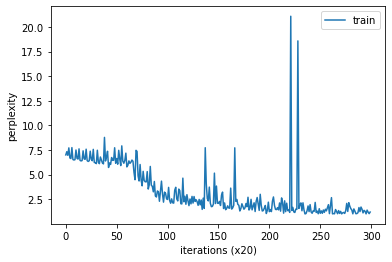

you say goodbye and i say hello


In [49]:
# hypter parameter
batch_size = 1
wordvec_size = 10
hidden_size = 10 # RNNの隠れ状態ベクトルの要素数
time_size = 3  # Truncated BPTTの展開する時間サイズ
lr = 3
max_epoch = 300
max_grad = 0.25
dropout = 0.5

# training data
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
corpus_size = len(corpus)
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# generate model
model = BetterRNNLMGen(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr=lr)
trainer = RNNLMTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, print_loss=False)
trainer.plot()

# generate text
model.reset_state()

start_word = 'you'
start_id = word_to_id[start_word]
word_ids = model.generate(start_id, sample_size=7)
txt = ' '.join([id_to_word[word_id] for word_id in word_ids])
print(txt)

## Encoder, Decoder layer

In [51]:
# encoder, decoder

class Encoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    
    embed_W = 0.01 * np.random.randn(V, D).astype(np.float32)
    lstm_Wx = (np.random.randn(D, H*4) / np.sqrt(D)).astype(np.float32)
    lstm_Wh = (np.random.randn(H, H*4) / np.sqrt(H)).astype(np.float32)
    lstm_b = np.zeros(H*4).astype(np.float32)
    
    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)
    
    self.params = self.embed.params + self.lstm.params
    self.grads = self.embed.grads + self.lstm.grads
    self.hs = None
    
  def forward(self, xs):
    xs = self.embed.forward(xs)
    hs = self.lstm.forward(xs)
    self.hs = hs
    return hs[:, -1, :]
  
  def backward(self, dh):
    dhs = np.zeros_like(self.hs)
    dhs[:, -1, :] = dh
    
    dout = self.lstm.backward(dhs)
    dout = self.embed.backward(dout)
    return dout
  
  
class Decoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    
    embed_W = 0.01 * np.random.randn(V, D).astype(np.float32)
    lstm_Wx = (np.random.randn(D, H*4) / np.sqrt(D)).astype(np.float32)
    lstm_Wh = (np.random.randn(H, H*4) / np.sqrt(H)).astype(np.float32)
    lstm_b = np.zeros(H*4).astype(np.float32)
    affine_W = (np.random.randn(H, V) / np.sqrt(H)).astype(np.float32)
    affine_b = np.zeros(V).astype(np.float32)
    
    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
    self.affine = TimeAffine(affine_W, affine_b)
    
    self.params, self.grads = [], []
    for layer in (self.embed, self.lstm, self.affine):
      self.params += layer.params
      self.grads += layer.grads
      
  def forward(self, xs, h):
    self.lstm.set_state(h)
    
    out = self.embed.forward(xs)
    out = self.lstm.forward(out)
    score = self.affine.forward(out)
    return score
  
  def backward(self, dscore):
    dout = self.affine.backward(dscore)
    dout = self.lstm.backward(dout)
    dout = self.embed.backward(dout)
    dh = self.lstm.dh
    return dh
  
  def generate(self, h, start_id, sample_size):
    self.lstm.set_state(h)
    
    sampled = []
    sample_id = start_id
    
    for _ in range(sample_size):
      x = np.array(sample_id).reshape((1,1))
      out = self.embed.forward(x)
      out = self.lstm.forward(out)
      score = self.affine.forward(out)
      
      sample_id = np.argmax(score.flatten())
      sampled.append(int(sample_id))
    
    return sampled
  

class PeekyDecoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    
    embed_W = 0.01 * np.random.randn(V, D).astype(np.float32)
    lstm_Wx = (np.random.randn(H + D, H*4) / np.sqrt(D)).astype(np.float32)
    lstm_Wh = (np.random.randn(H, H*4) / np.sqrt(H)).astype(np.float32)
    lstm_b = np.zeros(H*4).astype(np.float32)
    affine_W = (np.random.randn(H + H, V) / np.sqrt(H)).astype(np.float32)
    affine_b = np.zeros(V).astype(np.float32)
    
    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
    self.affine = TimeAffine(affine_W, affine_b)
    
    self.params, self.grads = [], []
    for layer in (self.embed, self.lstm, self.affine):
      self.params += layer.params
      self.grads += layer.grads 
      
    self.cache = None
      
  def forward(self, xs, h):
    N, T = xs.shape
    N, H = h.shape
    
    self.lstm.set_state(h)
    
    out = self.embed.forward(xs)
    
    hs = np.repeat(h, T, axis=0).reshape(N, T, -1)
    out = np.concatenate((hs, out), axis=2)
    out = self.lstm.forward(out)
    
    out = np.concatenate((hs, out), axis=2)
    score = self.affine.forward(out)
    
    self.cache = H
    return score
  
  def backward(self, dscore):
    H = self.cache
    
    dout = self.affine.backward(dscore)
    dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
    
    dout = self.lstm.backward(dout)
    dout, dhs1 = dout[:, :, H:], dout[:, :, :H]
    
    self.embed.backward(dout)
    
    dhs = dhs0 + dhs1
    dh = self.lstm.dh + np.sum(dhs, axis=1)
    return dh
  
  def generate(self, h, start_id, sample_size):
    self.lstm.set_state(h)
    
    sampled = []
    sample_id = start_id
    
    H = h.shape[1]
    peeky_h = h.reshape(1, 1, H)   
    for _ in range(sample_size):
      x = np.array(sample_id).reshape((1,1))
      out = self.embed.forward(x)
      
      out = np.concatenate((peeky_h, out), axis=2)
      out = self.lstm.forward(out)
      out = np.concatenate((peeky_h, out), axis=2)
      score = self.affine.forward(out)
      
      sample_id = np.argmax(score.flatten())
      sampled.append(int(sample_id))
    
    return sampled    

## seq2seq

In [52]:
# seq2seq

class Seq2seq(BaseModel):
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    self.encoder = Encoder(V, D, H)
    self.decoder = Decoder(V, D, H)
    self.softmax = TimeSoftmaxWithLoss()
    
    self.params = self.encoder.params + self.decoder.params
    self.grads = self.encoder.grads + self.decoder.grads
    
  def forward(self, xs, ts):
    decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
    
    h = self.encoder.forward(xs)
    score = self.decoder.forward(decoder_xs, h)
    loss = self.softmax.forward(score, decoder_ts)
    return loss
  
  def backward(self, dout=1):
    dout = self.softmax.backward(dout)
    dh = self.decoder.backward(dout)
    dout = self.encoder.backward(dh)
    return dout
  
  def generate(self, xs, start_id, sample_size):
    h = self.encoder.forward(xs)
    sampled = self.decoder.generate(h, start_id, sample_size)
    return sampled
  

class PeekySeq2seq(Seq2seq):
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    self.encoder = Encoder(V, D, H)
    self.decoder = PeekyDecoder(V, D, H)
    self.softmax = TimeSoftmaxWithLoss()
    
    self.params = self.encoder.params + self.decoder.params
    self.grads = self.encoder.grads + self.decoder.grads

## training

### simple seq2seq

In [ ]:
import sequence

# dataset
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# hyper-parameter
vocab_size = len(id_to_char)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5

model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = AdaGrad()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch=1, 
              batch_size=batch_size, eval_interval=50, max_grad=max_grad,
              print_loss=False)
  
  correct_num = 0
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]
    verbose = i < 10
    correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose=False)
  
  acc = float(correct_num) / len(x_test)
  acc_list.append(acc)
  
  print('-' * 30)
  print('| epoch %d | val acc: %.3f%%' % (epoch, acc * 100))
  print('-' * 30)

simple_acc_list = acc_list

### reverse seq2seq

In [ ]:
# dataset
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
# reverse data
x_train, t_test = x_train[:, ::-1], x_test[:, ::-1]

char_to_id, id_to_char = sequence.get_vocab()

# hyper-parameter
vocab_size = len(id_to_char)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5

model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = AdaGrad()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch=1, 
              batch_size=batch_size, eval_interval=50, max_grad=max_grad,
              print_loss=False)
  
  correct_num = 0
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]
    verbose = i < 10
    correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose=False)
  
  acc = float(correct_num) / len(x_test)
  acc_list.append(acc)
  
  print('-' * 30)
  print('| epoch %d | val acc: %.3f%%' % (epoch, acc * 100))
  print('-' * 30)
  
reverse_acc_list = acc_list

### reverse + peeky seq2seq

In [ ]:
# dataset
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
# reverse data
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

char_to_id, id_to_char = sequence.get_vocab()

# hyper-parameter
vocab_size = len(id_to_char)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5

model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = AdaGrad()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch=1, 
              batch_size=batch_size, eval_interval=50, max_grad=max_grad,
              print_loss=False)
  
  correct_num = 0
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]
    verbose = i < 10
    correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose=False)
  
  acc = float(correct_num) / len(x_test)
  acc_list.append(acc)
  
  print('-' * 30)
  print('| epoch %d | val acc: %.3f%%' % (epoch, acc * 100))
  print('-' * 30)
  
peeky_reverse_acc_list = acc_list

### various seq2seq

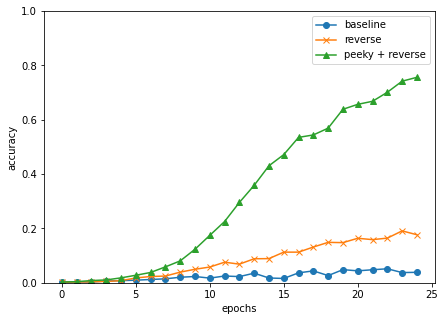

In [76]:
x = range(max_epoch)

acc_lists = [simple_acc_list, reverse_acc_list, peeky_reverse_acc_list]
markers = ['o', 'x', '^']
labels = ['baseline', 'reverse', 'peeky + reverse']

plt.figure(figsize=(7,5))
for i, acc_list in enumerate(acc_lists):
  plt.plot(x, acc_list, marker=markers[i], label=labels[i])
plt.ylim(0, 1)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# 8. Attention

## layers 

In [64]:
# layers

class WeightSum:
  def __init__(self):
    self.params, self.grads = [], []
    self.cache = None
    
  def forward(self, hs, a):
    N, T, H = hs.shape
    ar = a.reshape(N, T, -1).repeat(H, axis=2)
    t = hs * ar
    c = np.sum(t, axis=1)
    
    self.cache = (hs, ar)
    return c
  
  def backward(self, dc):
    hs, ar = self.cache
    N, T, H = hs.shape
    dt = dc.reshape(N, 1, H).repeat(T, axis=1)
    dhs = dt * ar
    da = np.sum(dt * hs, axis=2)
    
    return dhs, da
  
  
class AttentionWeight:
  def __init__(self):
    self.params, self.grads = [], []
    self.softmax = Softmax()
    self.cache = None
    
  def forward(self, hs, h):
    N, T, H = hs.shape
    hr = h.reshape(N, 1, H).repeat(T, axis=1)
    t = hs * hr
    s = np.sum(t, axis=2)
    a = self.softmax.forward(s)
    
    self.cache = (hs, hr)
    return a
    
  def backward(self, da):
    hs, hr = self.cache
    N, T, H = hs.shape
    
    ds = self.softmax.backward(da)
    dt = ds.reshape(N, T, 1).repeat(H, axis=2)
    dhs = dt * hr
    dhr = dt * hs
    dh = np.sum(dhr, axis=1)
    
    return dhs, dh
  

class Attention:
  def __init__(self):
    self.params, self.grads = [], []
    self.attention_weight_layer = AttentionWeight()
    self.weight_sum_layer = WeightSum()
    self.attention_weight = None
    
  def forward(self, hs, h):
    a = self.attention_weight_layer.forward(hs, h)
    out = self.weight_sum_layer.forward(hs, a)
    self.attention_weight = a
    return out
  
  def backward(self, dout):
    dhs0, da = self.weight_sum_layer.backward(dout)
    dhs1, dh = self.attention_weight_layer.backward(da)
    dhs = dhs0 + dhs1
    return dhs, dh

## time layers

In [68]:
# time layers

class TimeAttention:
  def __init__(self):
    self.params, self.grads = [], []
    self.layers = None
    self.attention_weights = None
    
  def forward(self, hs_enc, hs_dec):
    N, T, H = hs_dec.shape
    out = np.empty_like(hs_dec)
    self.layers = []
    self.attention_weights = []
    
    for t in range(T):
      layer = Attention()
      self.layers.append(layer)
      out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
      self.attention_weights.append(layer.attention_weight)
    
    return out
  
  def backward(self, dout):
    N, T, H = dout.shape
    dhs_enc = 0
    dhs_dec = np.empty_like(dout)
    
    for t in range(T):
      layer = self.layers[t]
      dhs, dh = layer.backward(dout[:, t, :])
      dhs_enc += dhs
      dhs_dec[:, t, :] = dh
      
    return dhs_enc, dhs_dec
  

class TimeBiLSTM:
  def __init__(self, Wx1, Wh1, b1, Wx2, Wh2, b2, stateful=False):
    self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
    self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
    self.params = self.forward_lstm.params + self.backward_lstm.params
    self.grads = self.forward_lstm.grads + self.backward_lstm.grads
    
  def forward(self, xs):
    out1 = self.forward_lstm.forward(xs)
    out2 = self.backward_lstm.forward(xs[:, ::-1])
    out2 = out2[:, ::-2]
    out = np.concatenate((out1, out2), axis=2)
    return out
  
  def backward(self, dhs):
    H = dhs.shape[2] // 2
    
    dhs1, dhs2 = dhs[:, :, :H], dhs[:, :, H:]
    dhs2 = dhs2[:, ::-1]
    dxs1 = self.forward_lstm.backward(dhs1)
    dxs2 = self.backward_lstm.backward(dhs2)
    dxs2 = dxs2[:, ::-1]
    dxs = dxs1 + dxs2
    return dxs

## seq2seq with Attention

In [58]:
# attention付きseq2seq

class AttentionEncoder(Encoder):
  def forward(self, xs):
    xs = self.embed.forward(xs)
    hs = self.lstm.forward(xs)
    return hs
  
  def backward(self, dhs):
    dout = self.lstm.backward(dhs)
    dout = self.embed.backward(dout)
    return dout
  

class AttentionDecoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    
    embed_W = 0.01 * np.random.randn(V, D).astype(np.float32)
    lstm_Wx = (np.random.randn(D, 4*H) / np.sqrt(D)).astype(np.float32)
    lstm_Wh = (np.random.randn(H, 4*H) / np.sqrt(H)).astype(np.float32)
    lstm_b = np.zeros(4*H).astype(np.float32)
    affine_W = (np.random.randn(H + H, V) / np.sqrt(H + H)).astype(np.float32)
    affine_b = np.zeros(V).astype(np.float32)
    
    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
    self.attention = TimeAttention()
    self.affine = TimeAffine(affine_W, affine_b)
    layers = [self.embed, self.lstm, self.attention, self.affine]
    
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads
      
  def forward(self, xs, hs_enc):
    h = hs_enc[:, -1, :]
    self.lstm.set_state(h)
    
    out = self.embed.forward(xs)
    hs_dec = self.lstm.forward(out)
    c = self.attention.forward(hs_enc, hs_dec)
    out = np.concatenate((c, hs_dec), axis=2)
    score = self.affine.forward(out)
    
    return score
  
  def backward(self, dscore):
    dout = self.affine.backward(dscore)
    N, T, H2 = dout.shape
    H = H2 // 2
    
    dc, dhs_dec0 = dout[:, :, :H], dout[:, :, H:]
    dhs_enc, dhs_dec1 = self.attention.backward(dc)
    dhs_dec = dhs_dec0 + dhs_dec1
    dout = self.lstm.backward(dhs_dec)
    dhs_enc[:, -1, :] += self.lstm.dh
    self.embed.backward(dout)
    
    return dhs_enc
  
  def generate(self, hs_enc, start_id, sample_size):
    sample_ids = []
    sample_id = start_id
    h = hs_enc[:, -1, :]
    self.lstm.set_state(h)
    
    for _ in range(sample_size):
      x = np.array([sample_id]).reshape((1,1))
      out = self.embed.forward(x)
      hs_dec = self.lstm.forward(out)
      c = self.attention.forward(hs_enc, hs_dec)
      out = np.concatenate((c, hs_dec), axis=2)
      score = self.affine.forward(out)
      
      sample_id = np.argmax(score.flatten())
      sample_ids.append(sample_id)
      
    return sample_ids
  

class AttentionSeq2seq(Seq2seq):
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    self.encoder = AttentionEncoder(V, D, H)
    self.decoder = AttentionDecoder(V, D, H)
    self.softmax = TimeSoftmaxWithLoss()
    
    self.params = self.encoder.params + self.decoder.params
    self.grads = self.encoder.grads + self.decoder.grads

## training

In [59]:
import sequence

In [67]:
# dataset
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# hyper-params
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

# training
model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
  
  correct_num = 0
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]
    correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose=False, is_reverse=True)
    
  acc = float(correct_num) / len(x_test)
  acc_list.append(acc)
  print('-' * 30)
  print('| epoch %d | val acc: %.3f%%' % (epoch + 1, acc * 100))
  print('-' * 30)
  
attention_acc_list = acc_list
model.save_params()

| epoch 1 |  iter 1 / 351 | time 2[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 26[s] | loss 3.09
| epoch 1 |  iter 41 / 351 | time 42[s] | loss 1.90
| epoch 1 |  iter 61 / 351 | time 55[s] | loss 1.72
| epoch 1 |  iter 81 / 351 | time 66[s] | loss 1.46
| epoch 1 |  iter 101 / 351 | time 76[s] | loss 1.19
| epoch 1 |  iter 121 / 351 | time 89[s] | loss 1.14
| epoch 1 |  iter 141 / 351 | time 102[s] | loss 1.09
| epoch 1 |  iter 161 / 351 | time 116[s] | loss 1.06
| epoch 1 |  iter 181 / 351 | time 133[s] | loss 1.04
| epoch 1 |  iter 201 / 351 | time 149[s] | loss 1.03
| epoch 1 |  iter 221 / 351 | time 163[s] | loss 1.02
| epoch 1 |  iter 241 / 351 | time 174[s] | loss 1.02
| epoch 1 |  iter 261 / 351 | time 186[s] | loss 1.01
| epoch 1 |  iter 281 / 351 | time 205[s] | loss 1.00
| epoch 1 |  iter 301 / 351 | time 218[s] | loss 1.00
| epoch 1 |  iter 321 / 351 | time 230[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 243[s] | loss 1.00
------------------------------
| epoch 0 |

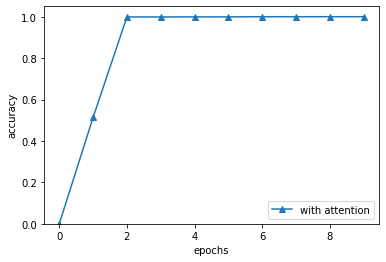

In [72]:
x = range(max_epoch)
plt.plot(x, attention_acc_list, marker='^', label='with attention')
plt.ylim(0, 1.05)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

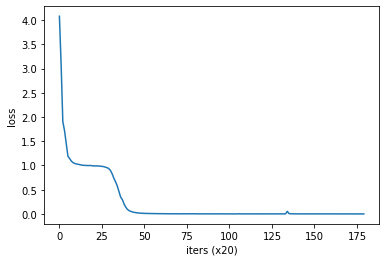

In [74]:
x = range(len(trainer.loss_list))
plt.plot(x, trainer.loss_list)
plt.xlabel('iters (x%d)' % trainer.eval_interval)
plt.ylabel('loss')
plt.show()

## visualize Attention

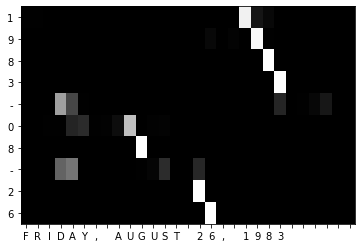

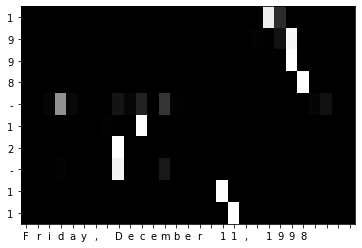

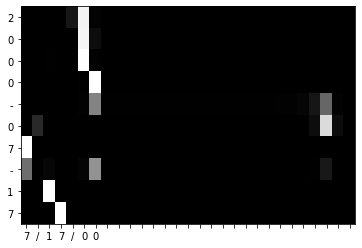

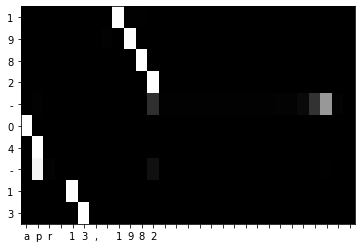

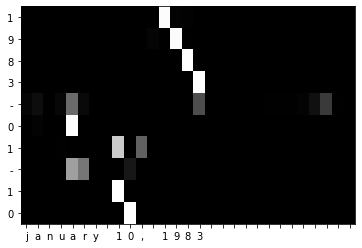

In [80]:
# dataset
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# reverse input
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0

def visualize(attention_map, row_labels, column_labels):
  fig, ax = plt.subplots()
  ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0, vmax=1)
  
  ax.patch.set_facecolor('black')
  ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
  ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
  ax.invert_yaxis()
  ax.set_xticklabels(row_labels, minor=False)
  ax.set_yticklabels(column_labels, minor=False)
  
  global _idx
  _idx += 1
  plt.show()
  

np.random.seed(1984)
for _ in range(5):
  idx = [np.random.randint(0, len(x_test))]
  x = x_test[idx]
  t = t_test[idx]
  
  model.forward(x, t)
  d = np.array(model.decoder.attention.attention_weights)
  attention_map = d.reshape(d.shape[0], d.shape[2])
  
  # reverse for print
  attention_map = attention_map[:, ::-1]
  x = x[:, ::-1]
  
  row_labels = [id_to_char[i] for i in x[0]]
  column_labels = [id_to_char[i] for i in t[0]][1:]
  
  visualize(attention_map, row_labels, column_labels)

# Appendix

## C. GRU 

In [82]:
class GRU:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None
  
  def forward(self, x, h_prev):
    Wx, Wh, b = self.params
    N, H = Wh.shape
    
    Wxr, Wxz, Wxh = Wx[:, :H], Wx[:, H:2*H], Wx[:, 2*H:]
    Whr, Whz, Whh = Wh[:, :H], Wh[:, H:2*H], Wh[:, 2*H:]
    br, bz, bh = b[:H], b[H:2*H], b[2*H:]
    
    r = sigmoid(x@Wxr + h_prev@Whr + br)
    z = sigmoid(x@Wxz + h_prev@Whz + bz)
    h_hat = tanh(x@Wxh + (r * h_prev)@Whh + bh)
    
    h_next = (1 - z) * h_prev + z * h_hat
    
    self.cache = (x, h_prev, r, z, h_hat)
    
    return h_next
  
  def backward(self, dh_next):
    Wx, Wh, b = self.params
    H = Wh.shape[0]
    Wxr, Wxz, Wxh = Wx[:, :H], Wx[:, H:2*H], Wx[:, 2*H:]
    Whr, Whz, Whh = Wh[:, :H], Wh[:, H:2*H], Wh[:, 2*H:]
    
    x, h_prev, r, z, h_hat = self.cache
    
    dh_hat = dh_next * z
    dh_prev = dh_next * (1 - z)
    
    # tanh
    dt = dh_hat * (1 - h_hat**2)
    dbh = np.sum(dt, axis=0)
    dWhh = (r * h_prev).T @ dt
    dhr = dt @ Whh.T
    dWxh = x.T @ dt
    dx = dt @ Wxh.T
    dh_prev += dhr * r
    
    # update gate (z)
    dz = dh_next * h_hat - dh_next * h_prev
    dt = dz * z * (1 - z)
    dbz = np.sum(dt, axis=0)
    dWhz = h_prev.T @ dt
    dh_prev += dt @ Whz.T
    dWxz = x.T @ dt
    dx += dt @ Wxz.T
    
    # reset gate (r)
    dr = dhr * h_prev
    dt = dr * r * (1 - r)
    dbr = np.sum(dt, axis=0)
    dWhr = h_prev.T @ dt
    dh_prev += dt @ Whr.T
    dWxr = x.T @ dt
    dx += dt @ Wxr.T
    
    self.dWx = np.hstack((dWxr, dWxz, dWxh))
    self.dWh = np.hstack((dWhr, dWhz, dWhh))
    self.db = np.hstack((dbr, dbz, dbh))
    
    self.grads[0][...] = self.dWx
    self.grads[1][...] = self.dWh
    self.grads[2][...] = self.db

    return dx, dh_prev
  
  
class TimeGRU:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None
    self.h, self.dh = None, None
    self.stateful = stateful
    
  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    H = Wh.shape[0]
    
    self.layers = []
    hs = np.empty((N, T, H), dtype=np.float32)
    
    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype=np.float32)
      
    for t in range(T):
      layer = GRU(Wx, Wh, b)
      self.layers.append(layer)
      self.h = layer.forward(xs[:, t, :], self.h)
      hs[:, t, :] = self.h
      
    return hs
  
  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D = Wx.shape[0]
    
    dxs = np.empty((N, T, D), dtype=np.float32)
    
    dh = 0
    grads = [0, 0, 0]
    
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh = layer.backward(dhs[:, t, :])
      dxs[:, t, :] = dx
      
      for i, grad in enumerate(layer.grads):
        grads[i] += grad
        
    for i, grad in enumerate(grads):
      self.grads[i] = grad
    
    self.dh = dh
    return dxs
  
  def set_state(self, h):
    self.h = h
    
  def reset_state(self):
    self.h = None